# Recommendation system

In [1]:
import pandas as pd

First step is to load data and perform first check of data validity. We will try to load data in format csv.

In [7]:
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding="latin-1")
users = pd.read_csv('BX-Users.csv', sep=';', encoding="latin-1")
# BX-Books.csv is not a valid csv file, it contains few mistakes => error_bad_lines=False
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


The next step is to preprocess data. Let's check our domains with sample data.  

In [8]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0


In [9]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...


In [6]:
users.head(1)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN


Now we can delete useless columns. Table `ratings` doesn't contain any useless information, but there are some columns from both `books` and `users` that are we don't need for our system. There are 3 image urls in books, but we *won't do* any image analysis so we can delete it. Other columns in `books` could be relevant so we can let them. 

In [7]:
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

There are also two columns in `users` that we won't work with - *location* and *age*. Actually, the columns could be really important hints, but we don't have location nor age of user for whom we are recommanding book - we can exclude it ```just(!)``` in this case. After excluding columns we can see that the table is useless for us and we won't work with it. Let's look at some statistics connected with age and location - just to validate data.

In [8]:
import matplotlib.pyplot as plt

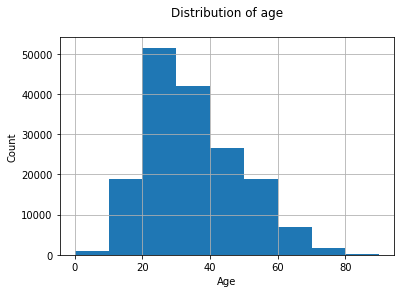

In [9]:
users.Age.hist(bins=list(range(0,100,10)))
plt.title('Distribution of age\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Well, does it mean that the majority of book readers are between people between 20 and 30 years? According to https://www.forbes.com/sites/daviddisalvo/2012/10/23/who-reads-the-most-in-the-us-the-answer-might-surprise-you/ it is possible.

In [10]:
from collections import Counter
sorted(Counter(list(map(lambda x: x.split(", ")[-1], users.Location))).items(), key=lambda i: i[1], reverse=True)[:10]

[('usa', 139711),
 ('canada', 21658),
 ('united kingdom', 18538),
 ('germany', 17043),
 ('spain', 13147),
 ('australia', 11784),
 ('italy', 11266),
 ('france', 3455),
 ('portugal', 3325),
 ('new zealand', 3097)]

Let's now look at correctness of values in rows. I will start with year of publication.

In [11]:
# there is also few invalid years
books.columns = ['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'publisher']
print(sorted(books.YearOfPublication.unique(), key=lambda x: str(x)))

[0, '0', '1376', '1378', 1806, '1897', 1900, '1900', 1901, 1902, 1904, 1906, 1908, '1909', 1910, 1911, '1911', 1914, 1917, '1919', 1920, '1920', 1921, '1922', 1923, '1923', 1924, '1924', 1925, 1926, '1926', 1927, '1927', 1928, 1929, 1930, '1930', 1931, '1931', 1932, '1932', 1933, '1933', 1934, 1935, 1936, '1936', 1937, 1938, '1938', 1939, '1939', 1940, '1940', 1941, '1941', 1942, '1942', 1943, '1943', 1944, '1944', 1945, '1945', 1946, '1946', 1947, '1947', 1948, '1948', 1949, '1949', 1950, '1950', 1951, '1951', 1952, '1952', 1953, '1953', 1954, '1954', 1955, '1955', 1956, '1956', 1957, '1957', 1958, '1958', 1959, '1959', 1960, '1960', 1961, '1961', 1962, '1962', 1963, '1963', 1964, '1964', 1965, '1965', 1966, '1966', 1967, '1967', 1968, '1968', 1969, '1969', 1970, '1970', 1971, '1971', 1972, '1972', 1973, '1973', 1974, '1974', 1975, '1975', 1976, '1976', 1977, '1977', 1978, '1978', 1979, '1979', 1980, '1980', 1981, '1981', 1982, '1982', 1983, '1983', 1984, '1984', 1985, '1985', 1986, '

Actual situation is unfit. We need to repair years as string and some text values. There is need to investigate wrong text values.

In [12]:
books.loc[books.YearOfPublication == 'Gallimard',:]

,ISBN,BookTitle,BookAuthor,YearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [13]:
books.loc[books.ISBN == '0789466953','YearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','BookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','BookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [14]:
books.loc[books.ISBN == '078946697X','YearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','BookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','BookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [15]:
books.loc[books.ISBN == '2070426769','YearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','BookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','BookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [16]:
books.YearOfPublication=pd.to_numeric(books.YearOfPublication)

In [17]:
sorted(Counter(books.YearOfPublication).items(), key=lambda i: i[1], reverse=True)[:10]

[(2002, 17627),
 (1999, 17431),
 (2001, 17359),
 (2000, 17234),
 (1998, 15766),
 (1997, 14890),
 (2003, 14359),
 (1996, 14030),
 (1995, 13546),
 (1994, 11796)]

Just to see frequency of years of publications in out dataset. It is also possible because chance to write a book are in this age better than in the past. 

In [18]:
books.loc[books.YearOfPublication == 2037,:]

,ISBN,BookTitle,BookAuthor,YearOfPublication,publisher
255409,068471809X,To Have and Have Not,Ernest Hemingway,2037,Simon &amp; Schuster


Book is originally publicated in 1937. Just missclick.

In [19]:
books.loc[books.YearOfPublication == 2050,:]

,ISBN,BookTitle,BookAuthor,YearOfPublication,publisher
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA


This is unfortunatelly not rule.

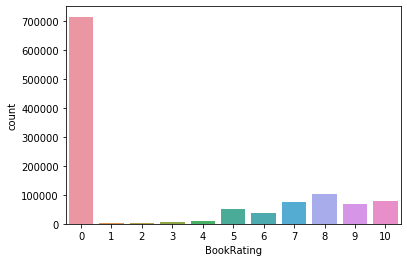

In [20]:
import seaborn as sns
ratings.columns = ['UserID', 'ISBN', 'BookRating']
sns.countplot(data=ratings , x='BookRating')
plt.show()

We can see that most of people who read book did't let any rating. 

In [21]:
rating_pairs = sorted(Counter(list(ratings.BookRating)).items(), key=lambda i: i[1], reverse=True)[:10]
print(rating_pairs)
non_zero = sum(i[1] for i in rating_pairs if i[0]==0)
print(f"Count of non zero values is {non_zero} what is {100*non_zero/sum(i[1] for i in rating_pairs)} percent of ratings.")

[(0, 716109), (8, 103736), (10, 78610), (7, 76457), (9, 67541), (5, 50974), (6, 36924), (4, 8904), (3, 5996), (2, 2759)]
Count of non zero values is 716109 what is 62.3782893877231 percent of ratings.


Maybe we shouldn't be interested in "zero ratings" becasue we want to recommend people books that they will like, not books that are read people like them. 

In [23]:
non_zero_ratings = ratings[ratings.BookRating != 0]
sorted(Counter(non_zero_ratings.ISBN).items(), key=lambda i: i[1], reverse=True)[:10]

[('0316666343', 707),
 ('0971880107', 581),
 ('0385504209', 487),
 ('0312195516', 383),
 ('0679781587', 333),
 ('0060928336', 320),
 ('059035342X', 313),
 ('0142001740', 307),
 ('0446672211', 295),
 ('044023722X', 281)]

In [24]:
sorted(Counter(ratings.ISBN).items(), key=lambda i: i[1], reverse=True)[:10]

[('0971880107', 2502),
 ('0316666343', 1295),
 ('0385504209', 883),
 ('0060928336', 732),
 ('0312195516', 723),
 ('044023722X', 647),
 ('0679781587', 639),
 ('0142001740', 615),
 ('067976402X', 614),
 ('0671027360', 586)]

In [25]:
non_zero_ratings.loc[non_zero_ratings.ISBN == '0316666343',:].BookRating.sum()

5787

In [27]:
non_zero_ratings.BookRating.mean() #TODO

7.601066246071331

Way to convert book to vector is f.e. feature extracton using Matrix factorisation.